In [55]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pyplot import savefig
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from sklearn.ensemble import AdaBoostRegressor
from tsfresh.utilities.dataframe_functions import impute
from matplotlib import pyplot
from tsfresh import extract_features

plt.style.use('seaborn')
import seaborn as sns

from tqdm import tqdm

In [25]:
time_series = pd.read_csv('commit_data.csv', header=None, names = ["Date", "Y"])
time_series = time_series.set_index("Date")
time_series.head()

,Y
Date,
2018-06-08 16:00:00,26
2018-06-08 17:00:00,0
2018-06-08 18:00:00,0
2018-06-08 19:00:00,0
2018-06-08 20:00:00,0


In [27]:
import tsfresh
df_shift, y = make_forecasting_frame(time_series["Y"], kind="number", max_timeshift=20, rolling_direction=1)
df_shift.head()

/miniconda3/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)


,time,value,id,kind
103360,2018-06-08 16:00:00,26.0,2018-06-08 17:00:00,number
97911,2018-06-08 16:00:00,26.0,2018-06-08 18:00:00,number
103361,2018-06-08 17:00:00,0.0,2018-06-08 18:00:00,number
92463,2018-06-08 16:00:00,26.0,2018-06-08 19:00:00,number
97912,2018-06-08 17:00:00,0.0,2018-06-08 19:00:00,number


In [28]:
%%capture
X = extract_features(df_shift, column_id="id", column_sort="time", column_value="value", impute_function=impute,
                     show_warnings=False)
X["feature_last_value"] = y.shift(1)
X = X.iloc[1:, ]
y = y.iloc[1: ]

In [29]:
X.head()

variable,value__abs_energy,value__absolute_sum_of_changes,"value__agg_autocorrelation__f_agg_""mean""","value__agg_autocorrelation__f_agg_""median""","value__agg_autocorrelation__f_agg_""var""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","value__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""",...,value__time_reversal_asymmetry_statistic__lag_2,value__time_reversal_asymmetry_statistic__lag_3,value__value_count__value_-inf,value__value_count__value_0,value__value_count__value_1,value__value_count__value_inf,value__value_count__value_nan,value__variance,value__variance_larger_than_standard_deviation,feature_last_value
id,,,,,,,,,,,,,,,,,,,,,
2018-06-08 18:00:00,676.0,26.0,-1.000000,-1.000000,0.000000,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,169.000000,1.0,0.0
2018-06-08 19:00:00,676.0,26.0,-0.625000,-0.625000,0.140625,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,150.222222,1.0,0.0
2018-06-08 20:00:00,676.0,26.0,-0.481481,-0.333333,0.142661,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,126.750000,1.0,0.0
2018-06-08 21:00:00,676.0,26.0,-0.401042,-0.270833,0.132243,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,108.160000,1.0,0.0
2018-06-08 22:00:00,677.0,27.0,-0.324410,-0.218722,0.077494,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,1.0,0.0,0.0,92.583333,1.0,1.0


In [31]:
ada = AdaBoostRegressor(n_estimators=10)
y_pred = [np.NaN] * len(y)

isp = 100   # index of where to start the predictions
assert isp > 0

for i in tqdm(range(isp, len(y))):
    
    ada.fit(X.iloc[:i], y[:i])
    y_pred[i] = ada.predict(X.iloc[i, :].values.reshape((1, -1)))[0]
    
y_pred = pd.Series(data=y_pred, index=y.index)

100%|██████████| 5349/5349 [1:48:16<00:00,  1.92s/it]


In [32]:
# Dataframe of predictions and true values
ys = pd.concat([y_pred, y], axis = 1).rename(columns = {0: 'pred', 'value': 'true'})

# Convert index to a datetime
ys.index = pd.to_datetime(ys.index)
ys.head()

,pred,true
Date,,
2018-06-08 18:00:00,NaN,0
2018-06-08 19:00:00,NaN,0
2018-06-08 20:00:00,NaN,0
2018-06-08 21:00:00,NaN,1
2018-06-08 22:00:00,NaN,0


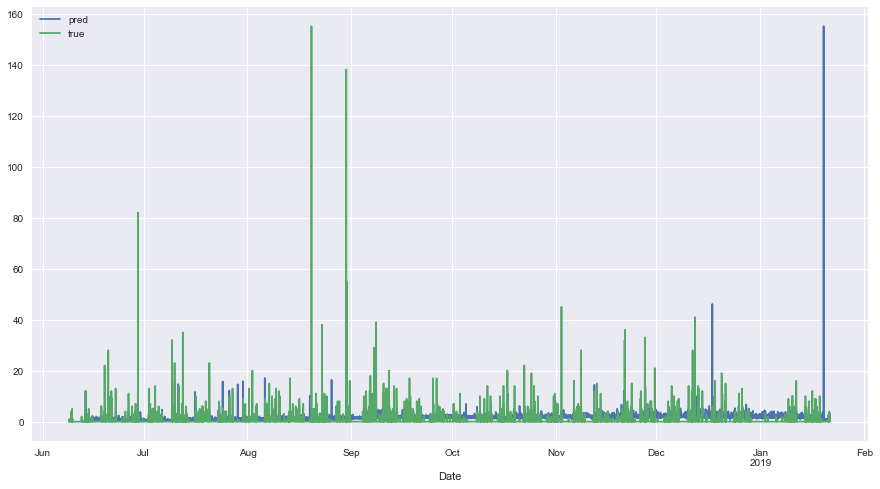

In [58]:
#plt.figure(figsize=(15, 6))
#plt.plot(y, label="true")
#plt.plot(y_pred, label="predicted")
#plt.legend()
#plt.show()
ys.plot(figsize=(15, 8))
savefig("plot5000Ada10.png")

In [53]:
print("MAE ada: \t{}".format(mean_absolute_error(y[isp:], y_pred[isp:])))
print("MSE ada: \t{}".format(mean_squared_error(y[isp:], y_pred[isp:])))
count = 0
truePred = 0
for idx, val in y_pred.iteritems():
    count += 1
    if val < 1 and y[idx] < 1:
        truePred += 1

print("Update metric: \t{}%".format(truePred/count*100))

count = 0
truePred = 0
for idx, val in y_pred.iteritems():
    count += 1
    if abs(val - y[idx]) <= 1:
        truePred += 1

print("Delta metric: \t{}%".format(truePred/count*100))

MAE ada: 	2.1249911347216925
MSE ada: 	23.97739423817091
Update metric: 	15.06698476784731%
Delta metric: 	23.619012662873924%
